In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


# **Set up the NBA API Data**

In [ ]:
pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.0/319.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
from nba_api.stats.endpoints import leaguedashteamstats

In [ ]:
### A list to guide our DataFrame
full_team_list = [
    'Atlanta Hawks','Boston Celtics','Brooklyn Nets','Charlotte Hornets','Chicago Bulls',
    'Cleveland Cavaliers','Dallas Mavericks','Denver Nuggets','Detroit Pistons',
    'Golden State Warriors','Houston Rockets','Indiana Pacers','LA Clippers',
    'Los Angeles Lakers','Memphis Grizzlies','Miami Heat','Milwaukee Bucks',
    'Minnesota Timberwolves','New Orleans Pelicans','New York Knicks',
    'Oklahoma City Thunder','Orlando Magic','Philadelphia 76ers','Phoenix Suns',
    'Portland Trail Blazers','Sacramento Kings','San Antonio Spurs','Toronto Raptors',
    'Utah Jazz','Washington Wizards'
]

In [ ]:
### Function to get advanced stats
def get_adv_stats(season):
    advStats = leaguedashteamstats.LeagueDashTeamStats(season=season, per_mode_detailed='Per100Possessions', measure_type_detailed_defense='Advanced')
    advStats_df = advStats.get_data_frames()[0]
    advStatsNBA = advStats_df[advStats_df['TEAM_NAME'].isin(full_team_list)].copy()
    advStatsNBA.reset_index(drop=True, inplace=True)

    advStats_cols = ['TEAM_NAME','W_PCT','OFF_RATING','DEF_RATING','NET_RATING','AST_PCT','AST_TO','OREB_PCT','DREB_PCT','EFG_PCT','TS_PCT','PACE']
    advStatsNBA_slim = advStatsNBA[advStats_cols].copy()
    return advStatsNBA_slim

In [ ]:
### Function to get defensive stats
def get_def_stats(season):
    DEFstats = leaguedashteamstats.LeagueDashTeamStats(season=season, per_mode_detailed='Per100Possessions', measure_type_detailed_defense='Opponent')
    DEFstats_df = DEFstats.get_data_frames()[0]
    DEFstatsNBA = DEFstats_df[DEFstats_df['TEAM_NAME'].isin(full_team_list)].copy()
    DEFstatsNBA.reset_index(drop=True, inplace=True)

    DEFstats_cols = ['TEAM_NAME','OPP_FG_PCT','OPP_FG3_PCT','OPP_TOV','OPP_BLK','PLUS_MINUS']
    DEFstatsNBA_slim = DEFstatsNBA[DEFstats_cols].copy()
    return DEFstatsNBA_slim

In [ ]:
### Function to get next year's win percentage
def get_win_pct_only(season):
    stats = leaguedashteamstats.LeagueDashTeamStats(season=season, per_mode_detailed='Per100Possessions', measure_type_detailed_defense='Advanced')
    stats_df = stats.get_data_frames()[0]
    statsNBA = stats_df[stats_df['TEAM_NAME'].isin(full_team_list)].copy()
    statsNBA.reset_index(drop=True, inplace=True)

    winpct = statsNBA[['TEAM_NAME','W_PCT']].copy()
    return winpct

In [ ]:
### Function to create a master DataFrame
def build_dataset(feature_season, target_season):
    adv = get_adv_stats(feature_season)
    defstats = get_def_stats(feature_season)
    target = get_win_pct_only(target_season)
    target.rename(columns={'W_PCT':'Next_Season_W_PCT'}, inplace=True)

    df = pd.merge(adv, defstats, on='TEAM_NAME', how='left')
    df = pd.merge(df, target, on='TEAM_NAME', how='left')
    return df

In [ ]:
### Build our Datasets /// Start in 2015 to have Data for 30 teams
Data_2015 = build_dataset('2015-16', '2016-17')
time.sleep(2)
Data_2016 = build_dataset('2016-17', '2017-18')
time.sleep(2)
Data_2017 = build_dataset('2017-18', '2018-19')
time.sleep(2)
Data_2018 = build_dataset('2018-19', '2019-20')
time.sleep(2)
Data_2019 = build_dataset('2019-20', '2020-21')
time.sleep(2)
Data_2020 = build_dataset('2020-21', '2021-22')
time.sleep(2)
Data_2021 = build_dataset('2021-22', '2022-23')
time.sleep(2)
Data_2022 = build_dataset('2022-23', '2023-24')
time.sleep(2)

In [ ]:
### Combine Data from all 8 Seasons into a single Dataset
Final_df = pd.concat([Data_2015, Data_2016, Data_2017, Data_2018, Data_2019, Data_2020, Data_2021, Data_2022], ignore_index=True)
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TEAM_NAME          240 non-null    object 
 1   W_PCT              240 non-null    float64
 2   OFF_RATING         240 non-null    float64
 3   DEF_RATING         240 non-null    float64
 4   NET_RATING         240 non-null    float64
 5   AST_PCT            240 non-null    float64
 6   AST_TO             240 non-null    float64
 7   OREB_PCT           240 non-null    float64
 8   DREB_PCT           240 non-null    float64
 9   EFG_PCT            240 non-null    float64
 10  TS_PCT             240 non-null    float64
 11  PACE               240 non-null    float64
 12  OPP_FG_PCT         240 non-null    float64
 13  OPP_FG3_PCT        240 non-null    float64
 14  OPP_TOV            240 non-null    float64
 15  OPP_BLK            240 non-null    float64
 16  PLUS_MINUS         240 non

In [ ]:
Final_df.head()

,TEAM_NAME,W_PCT,OFF_RATING,DEF_RATING,NET_RATING,AST_PCT,AST_TO,OREB_PCT,DREB_PCT,EFG_PCT,TS_PCT,PACE,OPP_FG_PCT,OPP_FG3_PCT,OPP_TOV,OPP_BLK,PLUS_MINUS,Next_Season_W_PCT
0,Atlanta Hawks,0.585,104.6,100.8,3.9,0.663,1.71,0.234,0.698,0.516,0.552,97.63,0.432,0.338,16.4,5.1,-3.7,0.524
1,Boston Celtics,0.585,105.8,102.5,3.3,0.616,1.76,0.290,0.707,0.488,0.531,99.43,0.441,0.336,16.5,5.5,-3.2,0.646
2,Brooklyn Nets,0.256,102.4,109.7,-7.4,0.583,1.51,0.279,0.716,0.492,0.527,96.12,0.479,0.369,14.7,5.4,7.6,0.244
3,Charlotte Hornets,0.585,106.4,103.7,2.7,0.586,1.73,0.244,0.754,0.502,0.545,96.24,0.444,0.349,13.8,5.6,-2.8,0.439
4,Chicago Bulls,0.512,104.1,105.5,-1.4,0.591,1.64,0.290,0.714,0.487,0.526,96.60,0.441,0.345,12.2,5.8,1.5,0.500


# **Logistic Regression - Feature Importance**

In [ ]:
### Test most important features for ALL seasons Using LinearRegression
X = Final_df.drop(columns=['TEAM_NAME', 'Next_Season_W_PCT'])
y = Final_df['Next_Season_W_PCT']

linear_model = LinearRegression()
linear_model.fit(X, y)

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
coefficients.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
8,EFG_PCT,0.786917
9,TS_PCT,0.551639
12,OPP_FG3_PCT,0.532344
4,AST_PCT,0.413063
1,OFF_RATING,0.372066
0,W_PCT,0.306241
6,OREB_PCT,0.184705
7,DREB_PCT,0.179429
14,OPP_BLK,0.008115
13,OPP_TOV,0.005522


# **Random Forest Regressor - Feature Importance**

In [ ]:
### Test most important features for ALL seasons using Random Forest
X = Final_df.drop(columns=['TEAM_NAME', 'Next_Season_W_PCT'])
y = Final_df['Next_Season_W_PCT']

random_forest_model = RandomForestRegressor() ### Any parameters?
random_forest_model.fit(X, y)

random_forest_importance = pd.DataFrame({'Feature': X.columns, 'Importance': random_forest_model.feature_importances_})
random_forest_importance.sort_values(by='Importance', ascending=False, inplace=True)
random_forest_importance

,Feature,Importance
0,W_PCT,0.189469
3,NET_RATING,0.173025
15,PLUS_MINUS,0.104828
5,AST_TO,0.064771
14,OPP_BLK,0.050269
10,PACE,0.048746
4,AST_PCT,0.048408
6,OREB_PCT,0.046202
13,OPP_TOV,0.040396
7,DREB_PCT,0.038156


# **Gradient Boosting Regressor - Feature Importance**

In [ ]:
### Test most important features for ALL seasons using Gradient Boosting
X = Final_df.drop(columns=['TEAM_NAME', 'Next_Season_W_PCT'])
y = Final_df['Next_Season_W_PCT']

gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X, y)

gbr_importance = pd.DataFrame({'Feature': X.columns, 'Importance': gbr_model.feature_importances_})

gbr_importance.sort_values(by='Importance', ascending=False, inplace=True)
gbr_importance

,Feature,Importance
3,NET_RATING,0.209649
0,W_PCT,0.169543
15,PLUS_MINUS,0.074318
14,OPP_BLK,0.061227
11,OPP_FG_PCT,0.059888
4,AST_PCT,0.055724
10,PACE,0.055541
8,EFG_PCT,0.054472
5,AST_TO,0.051839
1,OFF_RATING,0.034033


# **Feature Importance Display**

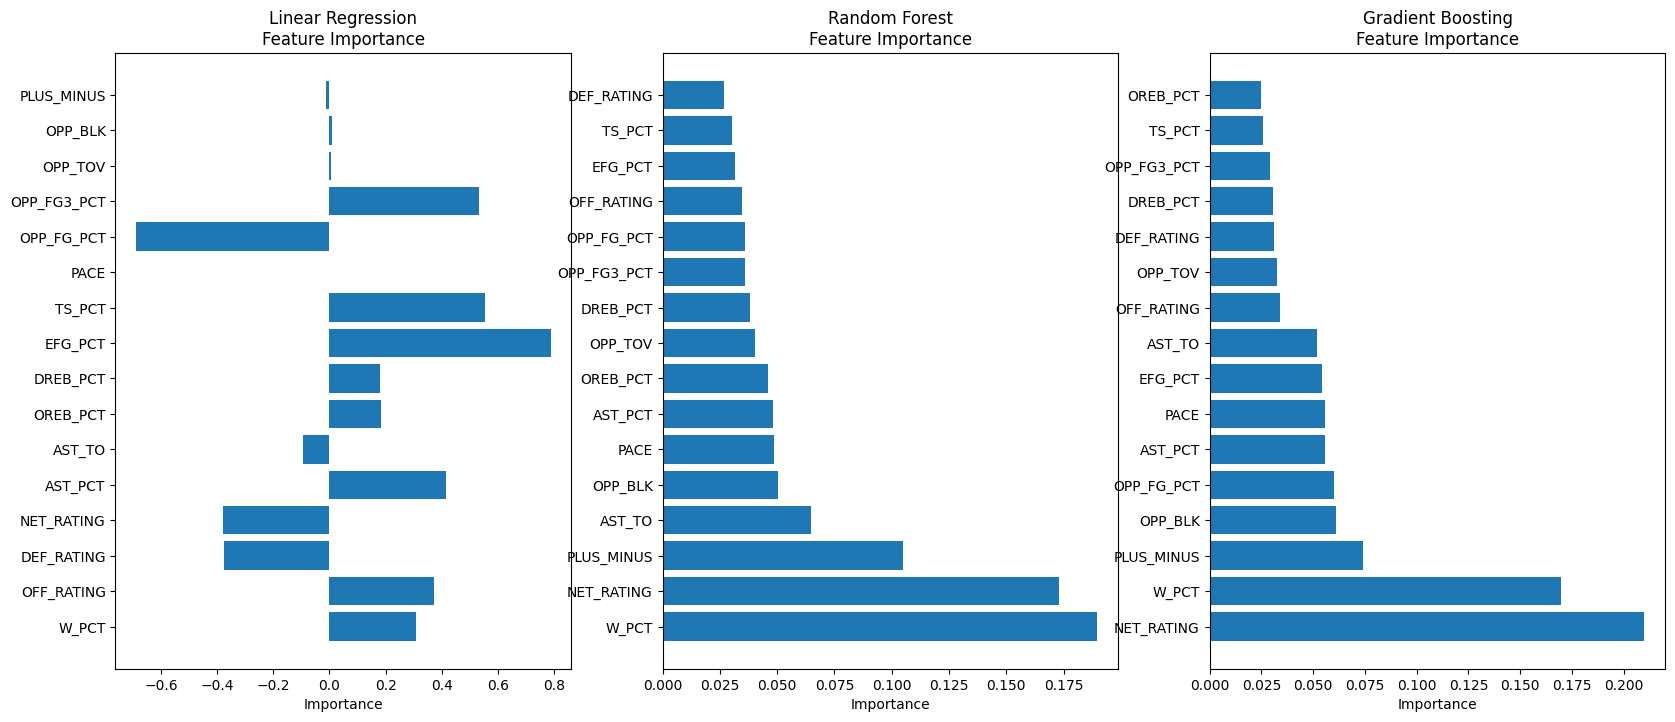

In [ ]:
### Display the feature importance for all 3 models
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

### Linear Regression
axes[0].barh(
    coefficients["Feature"],
    coefficients["Coefficient"])
axes[0].set_title("Linear Regression\nFeature Importance")
axes[0].set_xlabel("Importance")

### Random Forest
axes[1].barh(
    random_forest_importance["Feature"],
    random_forest_importance["Importance"])
axes[1].set_title("Random Forest\nFeature Importance")
axes[1].set_xlabel("Importance")

### Gradient Boosting
axes[2].barh(
    gbr_importance["Feature"],
    gbr_importance["Importance"])
axes[2].set_title("Gradient Boosting\nFeature Importance")
axes[2].set_xlabel("Importance")

plt.show()

# **Random Forest Regressor - Predictions**


In [ ]:
### Predict next season's win percentage for 2022 Season using Random Forest Classifier
X = Data_2022.drop(columns=['TEAM_NAME', 'Next_Season_W_PCT'])
y = Data_2022['Next_Season_W_PCT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

random_forest_model_2022 = RandomForestRegressor(random_state=42)
random_forest_model_2022.fit(X_train, y_train)

Data_2022['Predicted_Next_Season_W_PCT'] = random_forest_model_2022.predict(X)
Data_2022['Prediction_Error'] = (Data_2022['Predicted_Next_Season_W_PCT'] - Data_2022['Next_Season_W_PCT'])
Data_2022[['TEAM_NAME', 'W_PCT', 'Next_Season_W_PCT', 'Predicted_Next_Season_W_PCT','Prediction_Error']]

,TEAM_NAME,W_PCT,Next_Season_W_PCT,Predicted_Next_Season_W_PCT,Prediction_Error
0,Atlanta Hawks,0.500,0.439,0.48778,0.04878
1,Boston Celtics,0.695,0.780,0.69140,-0.08860
2,Brooklyn Nets,0.549,0.390,0.45471,0.06471
3,Charlotte Hornets,0.329,0.256,0.32174,0.06574
4,Chicago Bulls,0.488,0.476,0.48928,0.01328
5,Cleveland Cavaliers,0.622,0.585,0.56774,-0.01726
6,Dallas Mavericks,0.463,0.610,0.54046,-0.06954
7,Denver Nuggets,0.646,0.695,0.65101,-0.04399
8,Detroit Pistons,0.207,0.171,0.39077,0.21977
9,Golden State Warriors,0.537,0.561,0.56869,0.00769


In [ ]:
### How well does our model perform?
y_pred_test = random_forest_model_2022.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

r2, mae

(0.0686315135214286, 0.14150375000000004)

# **KNN - Predictions**

In [ ]:
### Predict next season's win percentage for 2022 Season using KNN
X = Data_2022.drop(columns=['TEAM_NAME', 'Next_Season_W_PCT'])
y = Data_2022['Next_Season_W_PCT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

knn_model_2022 = KNeighborsRegressor(n_neighbors=5)
knn_model_2022.fit(X_train_scaled, y_train)

Data_2022['Predicted_Next_Season_W_PCT_KNN'] = knn_model_2022.predict(X_scaled)
Data_2022['Prediction_Error_KNN'] = (Data_2022['Predicted_Next_Season_W_PCT_KNN'] - Data_2022['Next_Season_W_PCT'])
Data_2022[['TEAM_NAME', 'W_PCT', 'Next_Season_W_PCT','Predicted_Next_Season_W_PCT_KNN', 'Prediction_Error_KNN']]

,TEAM_NAME,W_PCT,Next_Season_W_PCT,Predicted_Next_Season_W_PCT_KNN,Prediction_Error_KNN
0,Atlanta Hawks,0.500,0.439,0.5416,0.1026
1,Boston Celtics,0.695,0.780,0.6488,-0.1312
2,Brooklyn Nets,0.549,0.390,0.5342,0.1442
3,Charlotte Hornets,0.329,0.256,0.3438,0.0878
4,Chicago Bulls,0.488,0.476,0.5684,0.0924
5,Cleveland Cavaliers,0.622,0.585,0.5708,-0.0142
6,Dallas Mavericks,0.463,0.610,0.5342,-0.0758
7,Denver Nuggets,0.646,0.695,0.6414,-0.0536
8,Detroit Pistons,0.207,0.171,0.3560,0.1850
9,Golden State Warriors,0.537,0.561,0.5634,0.0024


In [ ]:
### How well does our model perform?
y_pred_test_knn = knn_model_2022.predict(X_test_scaled)

r2_knn = r2_score(y_test, y_pred_test_knn)
mae_knn = mean_absolute_error(y_test, y_pred_test_knn)

r2_knn, mae_knn

(0.6629334900825263, 0.08174999999999996)

# **XGBoost - Predictions**

In [ ]:
### Predict next season's win percentage for 2022 Season using KNN
X = Data_2022.drop(columns=['TEAM_NAME', 'Next_Season_W_PCT'])
y = Data_2022['Next_Season_W_PCT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xgb_model_2022 = XGBRegressor(max_depth=3, random_state=42)

xgb_model_2022.fit(X_train, y_train)

Data_2022['Predicted_Next_Season_W_PCT_XGB'] = xgb_model_2022.predict(X)
Data_2022['Prediction_Error_XGB'] = (Data_2022['Predicted_Next_Season_W_PCT_XGB'] - Data_2022['Next_Season_W_PCT'])
Data_2022[['TEAM_NAME', 'W_PCT', 'Next_Season_W_PCT','Predicted_Next_Season_W_PCT_XGB', 'Prediction_Error_XGB']]

,TEAM_NAME,W_PCT,Next_Season_W_PCT,Predicted_Next_Season_W_PCT_XGB,Prediction_Error_XGB
0,Atlanta Hawks,0.500,0.439,0.438335,-0.000665
1,Boston Celtics,0.695,0.780,0.778827,-0.001173
2,Brooklyn Nets,0.549,0.390,0.389883,-0.000117
3,Charlotte Hornets,0.329,0.256,0.256142,0.000142
4,Chicago Bulls,0.488,0.476,0.475932,-0.000068
5,Cleveland Cavaliers,0.622,0.585,0.585817,0.000817
6,Dallas Mavericks,0.463,0.610,0.609861,-0.000139
7,Denver Nuggets,0.646,0.695,0.695226,0.000226
8,Detroit Pistons,0.207,0.171,0.269267,0.098267
9,Golden State Warriors,0.537,0.561,0.569963,0.008963


In [ ]:
### How well does our model perform?
y_pred_test = xgb_model_2022.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

r2, mae

(0.8015309095977813, 0.06294738906621933)